# Conditional dustributions in a multivariate distribution of the form "Gaussian copula with $t$ marginals"

This notebook contains illustrations for the Quant Room in the Risk Management in Credit Organizations Journal.

## Gaussian copula

Denote $N_{\mu,S}$ the CDF of multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $S$.

Let $Z$ be a random $d$-vector having CDF $N_{0, S}$ with standard normal marginals, so that $S$ is actually a correlation matrix. Denote $\Phi$ univariate standard normal CDF, we know that the vector $U=\Phi(Z)$ has a distribution in $[0,1]^d$, which is called "copula" of the distribution of $Z$. Denote $C_S$ the CDF of the latter distribution, it has uniform marginals, and correlation matrix $S$ is its parameter.

## Conditional Gaussian distribution

Let $I$ and $J$ be two subsets of indices in $\{1, \dots, d\}$, consider partition of the vector $Z$ and matrix $S$ of the form

$$
Z=\left(
\begin{array}{c}
Z_I\\ Z_J
\end{array}
\right),\;\;\;
S=\left(
\begin{array}{cc}
S_{II}&S_{IJ}\\ S_{JI}&S_{JJ}
\end{array}
\right);
$$

It is well known that conditional distribution of $Z_J$ given $Z_I=z_I$ is multivariate Gaussian with mean

$$
\mu_{J|I}(z_I)=E(Z_J|Z_I=z_I)=S_{JI}S_{II}^{-1}z_I
$$

and covariance matrix

$$
S_{J|I}=S_{JJ}-S_{JI}S_{II}^{-1}S_{IJ}.
$$

In other words, it has the CDF $N_\left\{\mu_{J|I}(z_I), S_{J|I}\right\}$.

## A counter-intuitive behavior of conditional correlations

There is intuitively appealing that if two components are highly correlated in marginal distribution, then they would also be significantly correlated in conditional distributions, given some values of other components fixed. However this is generally not the case; we show the behavior in a simple example.

In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import gaussian_copula_stuff as gcs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Create a correlation matrix with high correlations

In [2]:
cr = pd.DataFrame(np.array([[1, 0.93, 0.98], [0.93, 1, 0.98], [0.98, 0.98, 1]]))
print('Correlation matrix')
print(cr)
cr01m = cr.iloc[0, 1]
print('\nMarginal correlation between components 1 and 2: {0:.3f}'.format(cr01m))

Correlation matrix
      0     1     2
0  1.00  0.93  0.98
1  0.93  1.00  0.98
2  0.98  0.98  1.00

Marginal correlation between components 1 and 2: 0.930


Now simulate large number of samples from a Gaussian distribution with zero mean and covariance matrix created above. Then scatter a moderate sample (300 points) from the marginal distribution of components 0 and 1.

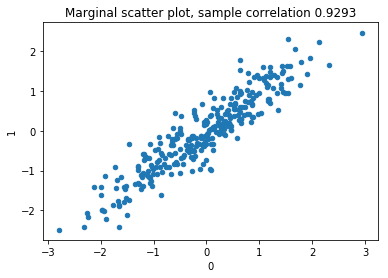

In [3]:
# simulate large number of samples
nn = 100000
z = pd.DataFrame(ss.multivariate_normal.rvs(cov=cr, size=nn))
crs = z.corr().iloc[0, 1]

# select just a moderate subsample for plotting
n_scat = 300
sel = np.random.choice(range(z.shape[0]), size=n_scat, replace=False)
zs = z.iloc[sel, :]
figsize(6, 4)
zs.plot.scatter(0, 1);
zs.to_csv('fig_01_a.csv', index=False)
title('Marginal scatter plot, sample correlation {0:.4f}'.format(crs));
savefig('fig_01_a.png')

Now compute the conditional distribution

In [4]:
def cov_to_corr(cv):
    """ converts covariance matrix to the correlation one """
    dd = pd.DataFrame(np.diag(np.sqrt(1 / np.diag(cv))), index=cv.columns, columns=cv.index)
    return dd.dot(cv).dot(dd)

# prepare data for computing conditional distribution of components 0, 1,
# given component 2 equals zero
II = [2]
JJ = [0, 1]
sII = cr.iloc[II, II]
sJJ = cr.iloc[JJ, JJ]
sIJ = cr.iloc[II, JJ]
sJI = cr.iloc[JJ, II]
sII1 = pd.DataFrame(np.linalg.inv(sII), index=sII.index, columns=sII.columns)

# covariance matrix of the conditional distribution
sJ_I = sJJ - sJI.dot(sII1).dot(sIJ)

# compute its correlation matrix for presenting the conditional correlation
crr = cov_to_corr(sJ_I)
cr01c = crr.iloc[0, 1]

print('Conditional correlation: {0:.4f}'.format(cr01c))

Conditional correlation: -0.7677


Now select the sample points with small second component absolute value (approximation of condition $Z_2=0$)

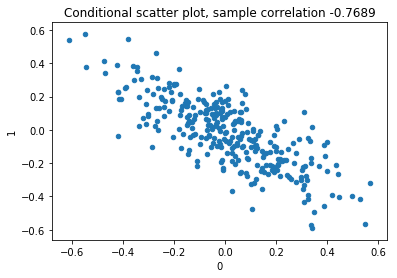

In [5]:
# select sample points approximately satisfying the condition Z_2 == 0
ind = (z[2].abs() < 0.01)
zi = z.loc[ind, :]
crsc = zi.corr().iloc[0, 1]

# select moderate number of points for plotting
siz = min(n_scat, zi.shape[0])
sel = np.random.choice(range(zi.shape[0]), size=siz, replace=False)
zs = zi.iloc[sel, :]
zs.to_csv('fig_01_b.csv', index=False)
figsize(6, 4)
zs.plot.scatter(0, 1);
title('Conditional scatter plot, sample correlation {0:.4f}'.format(crsc));
savefig('fig_01_b.png')

## Conditional copula distribution

Let again $Z$ be a random vector with CDF $N_{0, S}$, where $S$ is a correlation matrix, and $U=\Phi(Z)$; distribution of $U$ is the copula of $Z$. How can we compute conditional distribution of $U_J$ given that $U_I=u_I$?

Tha answer stems from the following chain

\begin{align}
P(U_J\leq u_J|U_I=u_I) &= P\left(\left.\Phi^{-1}(U_J)\leq \Phi^{-1}(u_J)\right|\Phi^{-1}(U_I)=\Phi^{-1}(u_I)\right)\\
&= P\left(\left.Z_J\leq\Phi^{-1}(u_J)\right|Z_I=\Phi^{-1}(u_I)\right)\\
&= N_\left\{\mu_{J|I}\left(\Phi^{-1}(u_I)\right),\;S_{J|I}\right\}\left(\Phi^{-1}(u_J)\right)
\end{align}

Thus we have a clear analytic expression of the conditional distribution in terms of multivariate Gaussian distribution. Consider examples.

In [6]:
# create Gaussian copula with artificial correlation matrix S
cop = gcs.GaussianCopula(corr_matr=cr)
print('Copula parameter (correlation matrix)')
print(cop.cr)

Copula parameter (correlation matrix)
      0     1     2
0  1.00  0.93  0.98
1  0.93  1.00  0.98
2  0.98  0.98  1.00


Now let $I=\{0, 1\}$ and $J=\{2\}$

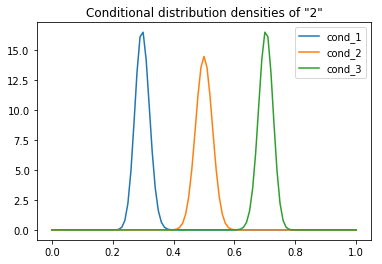

In [7]:
II = [0, 1]
JJ = [2]

# create U values for calculating CDFs and PDFs
u = pd.DataFrame(np.linspace(0, 1, 101), columns=JJ)

# create conditions
u_cond_1 = pd.DataFrame([[0.3, 0.3]], columns=II)
u_cond_2 = pd.DataFrame([[0.5, 0.5]], columns=II)
u_cond_3 = pd.DataFrame([[0.7, 0.7]], columns=II)

df = pd.DataFrame()
df['cond_1'] = cop.cond_pdf(u, u_cond_1)
df['cond_2'] = cop.cond_pdf(u, u_cond_2)
df['cond_3'] = cop.cond_pdf(u, u_cond_3)
df.plot();
title('Conditional distribution densities of "2"');
df.to_csv('fig_02.csv')
savefig('fig_02.png')

## Conditional distributions in a real-world example

Now consider a number of financial indices and stocks, and derive conditional distributions assuming Gaussian copula and $t$ marginals.

In [8]:
# prepare data
dfs = pd.read_csv('stocks.csv').set_index('date')
dfi = pd.read_csv('indices.csv').set_index('date').drop('stoxx50', axis=1)
cols = dfs.columns
coli = dfi.columns

# align stocks and indices data by date
dfj = dfs.join(dfi, how='inner')
dfs = dfj[cols].copy()
dfi = dfj[coli].copy()

# get percentiles for future use
dss = dfs.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
dsi = dfi.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

In [9]:
# create and fit multivariate distribution for stocks and indices returns
mvd = gcs.MultiVarDistribution()
mvd.fit(dfj)

In [10]:
def make_it(target='microsoft', fignum=None, prct=['10%', '50%', '90%']):
    """ """
    x_min = dss.loc['min', target]
    x_max = dss.loc['max', target]
    nn = 101
    xx = np.linspace(x_min, x_max, nn)
    x = pd.DataFrame(xx, columns=[target])
    x_cond_1 = dsi.loc[[prct[0]], :]
    x_cond_2 = dsi.loc[[prct[1]], :]
    x_cond_3 = dsi.loc[[prct[2]], :]
    dfp = pd.DataFrame()
    dfp['marg'] = pd.Series(mvd.marginal_pdf(xx, target), index=xx)
    dfp[prct[0]] = pd.Series(mvd.cond_pdf(x, x_cond_1).values, index=xx)
    dfp[prct[1]] = pd.Series(mvd.cond_pdf(x, x_cond_2).values, index=xx)
    dfp[prct[2]] = pd.Series(mvd.cond_pdf(x, x_cond_3).values, index=xx)
    dfp.index.name = 'return'
    dfp.plot();
    title('Marginal and conditional PDFs for "{0}"'.format(target));
    #xlabel('return');
    ylabel('PDF');
    if fignum is not None:
        dfp.to_csv('fig_{0}.csv'.format(fignum))
        savefig('fig_{0}.png'.format(fignum))

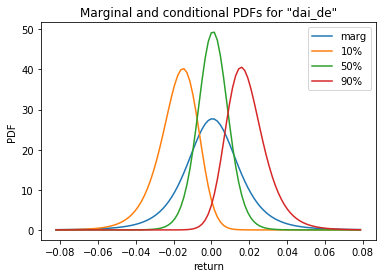

In [11]:
make_it(target=cols[6], fignum='03a')

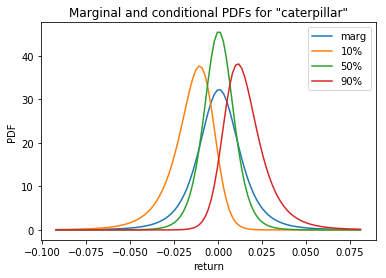

In [12]:
make_it(target=cols[16], fignum='03b')

Note that conditional distributions are NOT Student $t$ ones; moreover, they are skewed; this is clear especially under heavy conditions deviation from median value.

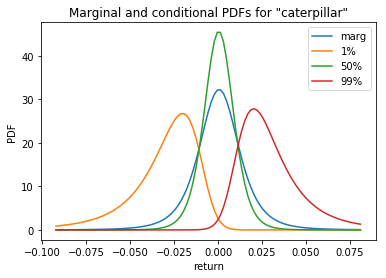

In [13]:
make_it(target=cols[16], prct=['1%', '50%', '99%'], fignum='04')

Below we also present conditional CDF plots, just for information.

In [14]:
def make_it_cdf(target='microsoft', prct=['10%', '50%', '90%']):
    """ """
    x_min = dss.loc['min', target]
    x_max = dss.loc['max', target]
    nn = 101
    xx = np.linspace(x_min, x_max, nn)
    x = pd.DataFrame(xx, columns=[target])
    x_cond_1 = dsi.loc[[prct[0]], :]
    x_cond_2 = dsi.loc[[prct[1]], :]
    x_cond_3 = dsi.loc[[prct[2]], :]
    dfp = pd.DataFrame()
    dfp['marg'] = pd.Series(mvd.marginal_cdf(xx, target), index=xx)
    dfp[prct[0]] = pd.Series(mvd.cond_cdf(x, x_cond_1).values, index=xx)
    dfp[prct[1]] = pd.Series(mvd.cond_cdf(x, x_cond_2).values, index=xx)
    dfp[prct[2]] = pd.Series(mvd.cond_cdf(x, x_cond_3).values, index=xx)
    dfp.plot();
    title('Marginal and conditional CDFs for "{0}"'.format(target));

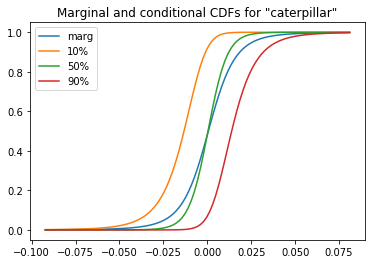

In [15]:
make_it_cdf(target=cols[16])